In [58]:
from OT_functions import *
import cvxpy as cp
import scipy
from scipy.linalg import null_space
from numpy.linalg import pinv

# Start Here

## Traditional QP approach

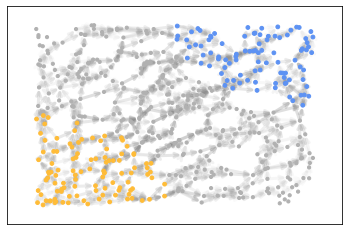

In [72]:
X = random_X()
nbrs = get_k_neighbors(X, 8)
pmf = make_uniform_pmf(X, [0,0], [1,1])
alpha = 2

G_Q, Q_weights, l = create_reg_digraph(X, nbrs, pmf, alpha, eps = 1e-10)
Q_weights = np.round(Q_weights, 8)
draw_digraph(G_Q)
plt.show()

In [73]:
old_W = sum(np.abs(Q_weights) * l + alpha/2 * Q_weights**2)
old_W

1.4782709797477183

## Algorithm:

In [74]:
# function that projects vec onto solution space of A*x = b
def proj(vec, A, b, verbose = False):
    if verbose: print(1)
    A_sparse = csc_matrix(A)
    vec = vec.reshape(-1,1)
    b = b.reshape(-1,1)
    
    if verbose: print(2)
    pinv_A = pinv(A.toarray())
    
    if verbose: print(3)
    return ((pinv_A @ (b - A @ vec)) + vec).flatten()

has_sign_change = None
def football(Q_sparse, l, pmf, alpha = 1):
    # project the origin onto S, the solution space of Q*w=p
    num_edges = Q_sparse.shape[1]
    print('projecting origin')
    origin_on_S = proj(np.zeros(num_edges), Q_sparse, pmf, verbose = True)

    # change sign of -l/alpha to be opposite of origin_on_S
    new_l = -np.sign(origin_on_S) * np.abs(l/alpha)

    # project new -l/alpha onto S
    print('projecting l')
    l_on_S = proj(new_l, Q_sparse, pmf, verbose = True)

    # find dimensions where origin_on_S and l_on_S are opposite in sign
    has_sign_change = np.sign(origin_on_S) != np.sign(l_on_S)

    # pretend to have perfect zeros:
    # has_sign_change = np.round(Q_weights, 8) == 0
#     for i in [0, 5, 47, 66, 73, 76]:
#         has_sign_change[i] = True
#     for i in [4, 20, 22, 23, 27, 30, 38, 42, 49, 72, 85, 93, 96]:
#         has_sign_change[i] = False

    # zero out dimensions where sign changed
    zeroed_new_l = np.where(has_sign_change, 0, new_l)          #maybe don't even need this?? can just use new_l?

    # create Q_ext, which is Q augmented with sliced identity matrix and pmf_ext
    num_trues = sum(has_sign_change)
    index_trues = np.where(has_sign_change)[0]

    E = np.zeros((num_trues, len(has_sign_change)))
    for i in range(num_trues):
        E[i, index_trues[i]] = 1

    Q_ext = scipy.sparse.vstack((Q_sparse, csc_matrix(E)))
    pmf_ext = np.append(pmf, np.zeros(num_trues))

    # project zeroed_new_l onto the solution space of Q_ext @ w = pmf_ext
    # pinv_Q_ext = np.linalg.pinv(Q_ext)
    print('making ')
    print('projecting zeroed l')
    min_w = proj(zeroed_new_l, csc_matrix(Q_ext), pmf_ext, verbose = True)
    print('done')
    
    return min_w, has_sign_change

##### Experiment

In [93]:
E = (np.identity(2307)[has_sign_change])
E_sparse = csc_matrix(E)
Q_ext = scipy.sparse.vstack((Q_sparse, E_sparse))

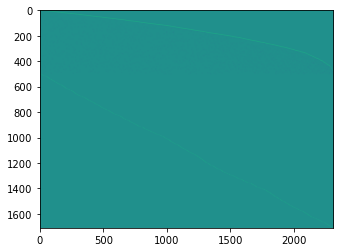

In [97]:
plt.imshow(Q_ext.toarray())

In [ ]:
Q_ext = scipy.sparse.vstack()

In [77]:
Q_sparse.shape

(500, 2307)

In [75]:
Q_sparse = make_Q(nbrs)
num_edges = Q_sparse.shape[1]
min_w, has_sign_change = football(Q_sparse, l, pmf)

new_W = np.abs(min_w) * l + alpha/2 * min_w**2
print('Total Weight: {}'.format(sum(new_W)))

projecting origin
1
2
3
projecting l
1
2
3
making 
projecting zeroed l
1
2
3
done
Total Weight: 1.6034486215902273


## Compare with QP

In [32]:
actual_zeros = np.where(np.round(Q_weights, 6) == 0)[0]
alg_zeros = np.where(np.round(min_w, 6) == 0)[0]
missed_zeros = actual_zeros[~np.isin(actual_zeros,alg_zeros)]
extra_zeros = alg_zeros[~np.isin(alg_zeros,actual_zeros)]
mystery_zeros = alg_zeros[~np.isin(alg_zeros, np.arange(num_edges)[has_sign_change])]

print('Zero-weight edges from QP:  ', '\n', actual_zeros)
print('Zero-weight edges from Alg: ', '\n', alg_zeros)
print('Edges with sign-change:     ', '\n', np.arange(num_edges)[has_sign_change])
print()
print('Alg should have found zeros at:      ', missed_zeros)
print('Alg should not have found zeros at:  ', extra_zeros)
print('Alg found zeros without sign change: ', mystery_zeros)

Zero-weight edges from QP:   
 [ 0  2  4  6 10 12 13 15 17 19 20 27 28 30 31 33 37 39 41 42 43 47 49 51
 53 54 56 57 58 62 64 71 73 75 78 79 82 84 87 89 90]
Zero-weight edges from Alg:  
 [ 0  2  4  6 10 12 13 15 17 19 20 24 27 28 29 30 33 35 37 39 41 42 43 44
 47 49 51 53 54 55 56 57 58 59 61 62 63 64 65 66 70 71 73 75 77 78 79 81
 82 84 87 89]
Edges with sign-change:      
 [ 0  2  4  6 10 12 13 15 17 19 20 24 27 28 29 30 33 35 37 39 41 42 43 44
 47 49 51 53 54 56 57 58 59 61 62 63 64 65 66 70 71 73 75 77 78 79 81 82
 84 87 89]

Alg should have found zeros at:       [31 90]
Alg should not have found zeros at:   [24 29 35 44 55 59 61 63 65 66 70 77 81]
Alg found zeros without sign change:  [55]


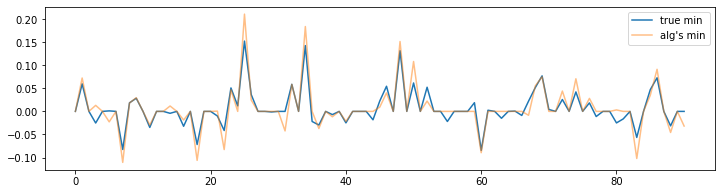

In [33]:
plt.figure(figsize = (12,3))
plt.plot(Q_weights, label = 'true min', alpha = 1)
plt.plot(min_w, label = "alg's min", alpha = .5)
plt.legend()

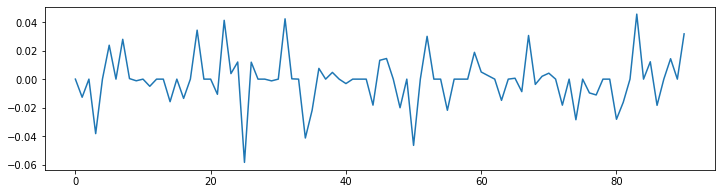

In [35]:
plt.figure(figsize = (12,3))
plt.plot(Q_weights - min_w)

In [11]:
(np.sign(np.round(Q_weights, 7)) - np.sign(np.round(min_w, 7)))* np.arange(num_edges)

array([   0.,    0.,    0.,    6.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,   12.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,  -21.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         36.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,   50.,    0.,    0.,    0.,
          0.,    0.,    0.,   57.,    0.,   59.,   60.,   61.,    0.,
          0.,    0.,   65.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,  -78.,   79.,   80.,
         81.,    0.,    0.,    0.,    0.,    0.,   87.,    0.,  -89.,
          0.,    0.,    0.,    0.,  -94.,    0.,    0.,    0.,  -98.,
          0.,    0.,    0.,  204., -206.,    0.])

In [10]:
min_w

array([-2.97559005e-04,  6.23457038e-16,  9.02950682e-17, -4.67292077e-02,
        4.34419551e-18,  2.89795088e-16,  1.10328112e-15,  1.64306369e-16,
       -4.20294208e-17,  4.99704734e-16,  7.83097875e-16,  7.63079699e-02,
       -2.92812032e-02,  1.11996851e-01,  1.96140566e-02,  1.10498444e-01,
       -7.61128368e-17, -3.14512530e-16, -1.34558310e-16,  7.95009036e-17,
        9.09264230e-02,  3.91565946e-16, -2.19199316e-16,  2.96369620e-16,
       -4.73513757e-16,  2.25369293e-16, -6.93535191e-02, -6.23621484e-02,
        4.25524541e-17,  1.35633352e-01, -6.18324190e-03,  1.26001460e-02,
        1.01662263e-01, -3.80584113e-16, -3.76406413e-16, -1.07610827e-15,
       -2.46010828e-16, -8.13052030e-02, -7.28916857e-02, -5.50735599e-16,
       -3.80158446e-16, -1.66312728e-02,  1.79698257e-01,  1.07439613e-02,
       -3.09906679e-16, -1.97085101e-02,  2.47182262e-16,  4.75358870e-17,
        1.97085101e-02,  5.85389598e-16,  8.75026347e-17, -5.55111512e-16,
        8.92788677e-16,  

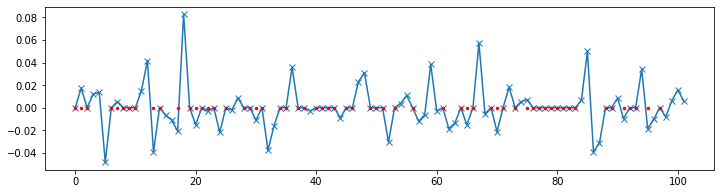

In [63]:
plt.figure(figsize = (12,3))
plt.plot(Q_weights - min_w, marker = 'x')
plt.plot(alg_zeros, np.zeros(len(alg_zeros)), color = 'r', linestyle = 'None', marker = '.', markersize = 5)
# plt.axvline(24, c = 'g')
# plt.ylim(-0.03, 0.03)

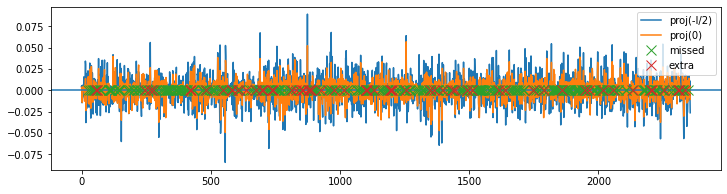

In [15]:
plt.figure(figsize = (12,3))
plt.plot(l_on_S, label = 'proj(-l/2)')
plt.plot(origin_on_S, label = 'proj(0)')
plt.axhline(0)
plt.plot(missed_zeros, np.zeros(len(missed_zeros)), linestyle = 'None', marker = 'x', markersize = 10, label = 'missed')
plt.plot(extra_zeros, np.zeros(len(extra_zeros)), linestyle = 'None', marker = 'x', markersize = 10, label = 'extra')

plt.legend()


In [463]:
test_change = np.sign(l_on_S) != np.sign(proj(-new_l, Q, pmf))
print(np.arange(num_edges)[test_change])
print(np.arange(num_edges)[has_sign_change])


[ 0  1  2  3  6  7  9 13 14 26 29 31 33 34 37 38 40 41 45 46 47 48 49 55
 57 59 60 62]
[ 0  1  2  3  7  9 13 14 29 31 33 34 37 38 41 45 46 47 48 49 57 60 62]


Notice:
* All extra zeros that are non-mysteries have blue lines close to 0

(-3.0, 3.0)

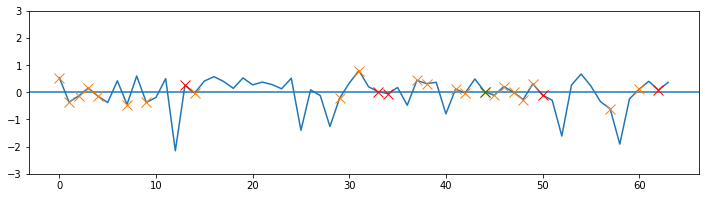

In [496]:
test = l_on_S / (origin_on_S + 0.2)

actual_zeros_bool = np.isin(np.arange(num_edges), actual_zeros)
plt.figure(figsize = (12,3))
plt.plot(test)
plt.axhline(0)
plt.plot(actual_zeros, test[actual_zeros_bool], linestyle = 'None', marker = 'x', markersize = 10, label = 'extra')
plt.plot(extra_zeros, test[np.isin(np.arange(num_edges), extra_zeros)], linestyle = 'None', marker = 'x', markersize = 10, label = 'extra', color = 'r')
plt.plot(missed_zeros, test[np.isin(np.arange(num_edges), missed_zeros)], linestyle = 'None', marker = 'x', markersize = 10, label = 'extra', color = 'g')

plt.ylim(-3, 3)

In [460]:
np.where(Q[:,44] != 0)

(array([ 8, 14], dtype=int64),)

In [344]:
actual_zeros

array([ 1,  4,  6,  8,  9, 11, 14, 19, 20, 21, 22, 27, 32, 36, 37, 38, 39,
       41, 42, 44, 47, 55, 57, 62], dtype=int64)

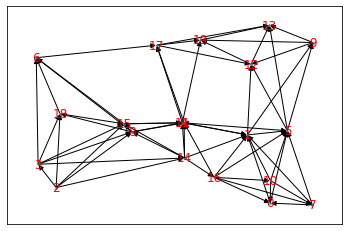

In [402]:
pos = nx.get_node_attributes(G_Q,'pos')
nx.drawing.nx_pylab.draw_networkx(G_Q, pos, with_labels = True, arrows = True, 
                                      arrowsize = 10, arrowstyle = '-|>',
                                      width = 1, node_size = 2, font_color = 'r')

In [203]:
np.mean(np.abs(l_on_S))

0.07888284292850498

In [101]:
origin_on_S[13]

-0.06552057835926442

In [384]:
rands = np.random.rand(num_edges, 100)
np.apply_along_axis(proj, 0, rands, Q, pmf)[52,:]

array([ 0.12928634,  0.02424084,  0.26759449,  0.10578401,  0.41676055,
        0.18958865, -0.03217842,  0.04948186, -0.0379356 ,  0.73145838,
        0.12961765,  0.72728257,  0.49288204,  0.1526182 ,  0.21540066,
        0.50921592,  0.56723346, -0.20777418,  0.11832875, -0.0418641 ,
        0.19945227,  0.16615712,  0.27300042,  0.35090342,  0.06294847,
       -0.00789861,  0.72378824, -0.16106319, -0.02614019,  0.61832878,
        0.0257323 ,  0.47861802,  0.34394051,  0.09178533,  0.23570772,
        0.48468652,  0.50148048, -0.01533446,  0.4357815 ,  0.11898504,
        0.2966688 ,  0.23947258,  0.15675268,  0.17463908,  0.36385576,
        0.27951748,  0.60455233,  0.08862838,  0.20874144, -0.06239743,
       -0.03189087,  0.21719789,  0.02118547,  0.13156719,  0.52915015,
        0.10086398,  0.44602268,  0.13411338,  0.46252415,  0.06236169,
        0.43220532, -0.15137324,  0.09152101,  0.04817441,  0.70374699,
        0.4159082 ,  0.36478858,  0.55539048,  0.46294153,  0.42

# Simulations

In [ ]:
n_sims = 300
data = np.zeros(n_sims, 2)
for i in range(n_sims):
    print(i)
    X = random_X()
    nbrs = get_k_neighbors(X, 8)
    pmf = make_uniform_pmf(X, [0,0], [1,1])
    
    w, l = get_reg_weights(X, nbrs, pmf)
    data[i][0] = sum(np.abs(w) * l + w**2)
    
    